<h1>Fine-Tuned Logistic Regression via Accuracy</h1>
<p>It was decided to explore what is the best result can be achieved with Logistic Regression Model.<br>
Accuracy serves as the Target Metric, because it is a straighforward approach that works regardless of the dataset.</p>

<h4>Imports</h4>

In [11]:
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
import joblib

import matplotlib.pyplot as plt

<h3>Loading train dataset</h3>

In [2]:
# Load train data
train_dataset = pd.read_csv('kmaml223/train.csv')#.sample(n=1000)

# Features to consider for classification
feature_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] 

In [3]:
train_dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_cleaned
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww match background colour 'm seemingly stu...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man 'm really trying edit war 's guy const...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,ca n't make real suggestion improvement wonder...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page 's


<h3>Splitting the Training Dataset</h3>

In [4]:
# Splitting train_data into training and testing subsets
train_subset, test_subset = train_test_split(train_dataset, test_size=0.2, random_state=42)

train_subset['comment_text_cleaned'].fillna('', inplace=True)
test_subset['comment_text_cleaned'].fillna('', inplace=True)

X_train = train_subset['comment_text_cleaned']
X_test = test_subset['comment_text_cleaned']

<h3>Creating a Logistic Regression Model for every feature</h3>

<h4>Method for Fine-Tuning using Accuracy as a metric</h4>

In [6]:
def get_best_logistic_regression_model_accuracy(train_data, train_labels):
    # Define hyperparameters and their distributions to sample from
    param_dist_lr = {
        'C': [0.1, 0.5, 1, 10, 100, 300, 1000, 100000],
        'penalty': ['l1', 'l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 300, 500, 700, 1000]
    }

    # Initialize the Logistic Regression model
    model_lr = LogisticRegression()

    # Perform randomized search to find the best combination of hyperparameters
    random_search_lr = RandomizedSearchCV(
        model_lr,
        param_dist_lr,
        scoring='accuracy',
        cv=5,
        random_state=42
    )

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

    # Fit the randomized search to your data
    random_search_lr.fit(X_train, y_train)

    # Get the best hyperparameters and the best model
    best_params_lr = random_search_lr.best_params_
    best_model_lr = random_search_lr.best_estimator_

    # Calculate accuracy on the validation dataset using the best model
    val_preds_lr = best_model_lr.predict(X_val)
    accuracy_lr = accuracy_score(y_val, val_preds_lr)

    print("Best Hyperparameters:", best_params_lr)
    print("Logistic Regression Accuracy:", accuracy_lr)

    return best_model_lr


<h4>Iterate through all the features storing the best Logistic Regression Model.</h4>

In [7]:
folder_name = "logistic_regression_accuracy"

In [8]:
models = {}

# Create a DataFrame to show accuracy and best hyperparameters for every model
results_list = []

# Preprocess text data, initialize and fit TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Save the TfidfVectorizer
tfidf_filename = f"models/{folder_name}/tfidf_vectorizer.pkl"
joblib.dump(tfidf_vectorizer, tfidf_filename)

for feature in feature_columns:
    print(f"===== Predicting for '{feature}' =====")
    
    y_train = train_subset[feature]  # Select the target feature    
    y_test = test_subset[feature]  # Select the target feature
    
    # Initialize and train Logistic Regression model
    logreg = get_best_logistic_regression_model_accuracy(X_train_tfidf, y_train)

    # Predict toxicity on test data
    predictions = logreg.predict(X_test_tfidf)
    
    # Store the trained model in the dictionary
    models[feature] = logreg

    # Save the trained model
    model_filename = f"models/{folder_name}/{feature}_model.pkl"
    joblib.dump(logreg, model_filename)

    # Get best hyperparameters for the feature
    best_params_lr = models[feature].get_params()
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    # Add results to the DataFrame
    results_list.append({'Feature': feature, 'Accuracy': accuracy, 'F1 Score': f1, 'Best Hyperparameters': best_params_lr})
    print()

===== Predicting for 'toxic' =====


/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/li

Best Hyperparameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'C': 100}
Logistic Regression Accuracy: 0.9553893153689488

===== Predicting for 'severe_toxic' =====


/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/li

Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500, 'C': 1}
Logistic Regression Accuracy: 0.9904825317248942

===== Predicting for 'obscene' =====


/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/li

Best Hyperparameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1000, 'C': 0.5}
Logistic Regression Accuracy: 0.9784584051386496

===== Predicting for 'threat' =====


/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/li

Best Hyperparameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'C': 100}
Logistic Regression Accuracy: 0.9974933416888611

===== Predicting for 'insult' =====


/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/li

Best Hyperparameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 700, 'C': 0.5}
Logistic Regression Accuracy: 0.9690192699357669

===== Predicting for 'identity_hate' =====


/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrew/Library/Python/3.9/li

Best Hyperparameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 700, 'C': 0.5}
Logistic Regression Accuracy: 0.9917750274165753



<h3>Comparison Table of Fine-Tuned Logistic Regression Models' Hyperparameters</h3>
<p>The code segment generates a comparison table summarizing the best hyperparameters for fine-tuned logistic regression models.</p>

In [20]:
# Create a DataFrame from the list of dictionaries
results = pd.DataFrame(results_list)

# Selecting only the relevant parameters from 'Best Hyperparameters'
relevant_params = ['C', 'penalty', 'solver', 'max_iter']
results['Best Hyperparameters'] = results['Best Hyperparameters'].apply(lambda x: {key: val for key, val in x.items() if key in relevant_params})

# Expand 'Best Hyperparameters' into separate columns
results = pd.concat([results.drop(['Best Hyperparameters'], axis=1), results['Best Hyperparameters'].apply(pd.Series)], axis=1)

# Set up a custom style for the DataFrame display
styled_results = results.style.format({'Accuracy': '{:.4f}'})
# Format other columns as needed

# Display the styled DataFrame
print("Comparison Table:")
display(styled_results)

Comparison Table:


,Feature,Accuracy,F1 Score,C,max_iter,penalty,solver
0,toxic,0.9575,0.756592,100.000000,100,l2,saga
1,severe_toxic,0.9908,0.374468,1.000000,500,l2,lbfgs
2,obscene,0.9778,0.763175,0.500000,1000,l1,saga
3,threat,0.9977,0.320755,100.000000,100,l2,saga
4,insult,0.9696,0.639106,0.500000,700,l1,saga
5,identity_hate,0.9917,0.333333,0.500000,700,l1,saga


<h3>ROC Curve Comparison of Fine-Tuned Linear Regression Models for Toxicity Labels</h3>
<p>This ROC curve graphic showcases the performance comparison of six distinct fine-tuned linear regression models, each tailored for predicting toxicity labels ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'). The curves depict the trade-off between true positive rates and false positive rates, providing insights into the models' discriminative abilities across various toxicity categories.</p>

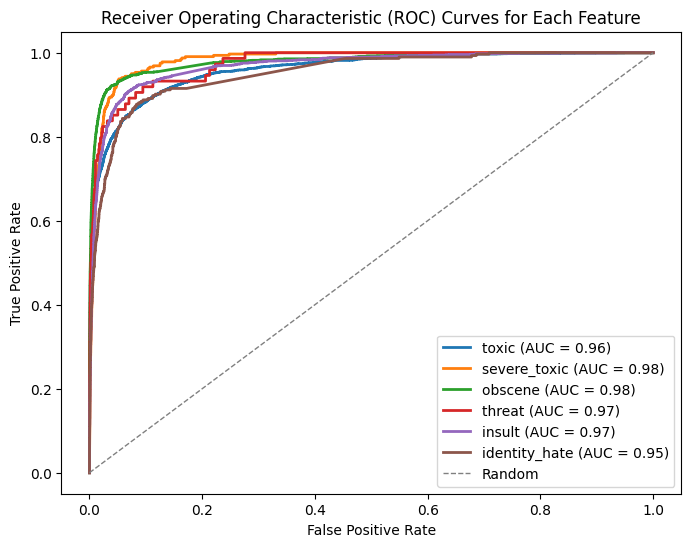

In [10]:
plt.figure(figsize=(8, 6))

for feature, model in models.items():
    # Get predicted probabilities for the positive class
    y_probs = model.predict_proba(X_test_tfidf)[:, 1]

    # Get true labels for the current feature
    y_true = test_subset[feature]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for the current feature
    plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (feature, roc_auc))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Each Feature')
plt.legend(loc='lower right')
plt.show()